In [28]:
import numpy as np
from scipy.interpolate import griddata
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter
# from scipy.misc import imsave
import imageio
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from stl import mesh, Mode
import matplotlib.tri as mtri
from mpl_toolkits.mplot3d.axes3d import get_test_data

from scipy.io import netcdf
from haversine_dist import calc_dist_lat_lon

In [36]:
def get_total_area(loc1, loc2, loc3, loc4):
    '''
      loc1-4 should be the bbox of interest. Should go clockwise starting from top left
      loc1 = top left
      loc2 = top right
      loc3 = bottom right
      loc4 = bottom left
    '''
    
    [lat1, lon1] = loc1
    [lat2, lon2] = loc2
    [lat3, lon3] = loc3
    [lat4, lon4] = loc4
    
    ##Calculate the haversine dist between all the points:
    ##loc1 to loc2 (width)
    width = calc_dist_lat_lon(lat1, lon1, lat2, lon2)
    ##loc2 to loc 3 (height)
    height = calc_dist_lat_lon(lat2, lon2, lat3, lon3)
    
    print ("width (km): ", width)
    print ("height (km) ", height)
    
    total_area = height*width
    print ("total area in km: ", total_area)
    
    ##5 knots = 9.26 km/hr
    
    total_search_days = total_area/(9.26*24)
    total_search_hours = total_area/9.26
    
    print (total_area/(9.26*24) % 24)
    print ("total search time (days): ", total_search_days)
    print ("total search time (hours): ", total_search_hours)
    return width*10, height*10

In [37]:
socal = netcdf.NetCDFFile('/home/msit/Desktop/southern_calif_crm_v1.nc')
temp = socal.variables.keys()
xog = socal.variables['x'][:]
yog = socal.variables['y'][:]
zog = socal.variables['z'][:]

loc1 = [32.858, -117.466]
loc2 = [32.858, -117.265]
loc3 = [32.66, -117.265]
loc4 = [32.66, -117.466]
places = np.array([loc1, loc2, loc3, loc4])
width, height = get_total_area(loc1, loc2, loc3, loc4)

min_lon = min(places[:,1])
max_lon = max(places[:,1])
xfilter = np.argwhere((xog <= max_lon) & (xog >= min_lon))
xclip = xog[xfilter].flatten()
xclip -= min(xclip)
xclip /= np.max(np.abs(xclip), axis=0)
xclip *= width

min_lat = min(places[:,0])
max_lat = max(places[:,0])
yfilter = np.argwhere((yog >= min_lat) & (yog<= max_lat))
yclip = yog[yfilter].flatten()
yclip -= min(yclip)
yclip /= np.max(np.abs(yclip), axis=0)
yclip *= height

x, y = np.meshgrid(xclip, yclip)
z = zog[yfilter[0][0]:yfilter[-1][0]+1, xfilter[0][0]:xfilter[-1][0]+1].flatten()

width (km):  18.774546561025755
height (km)  22.01659547562253
total area in km:  413.35159687234415
1.8599333912542482
total search time (days):  1.8599333912542482
total search time (hours):  44.63840139010196


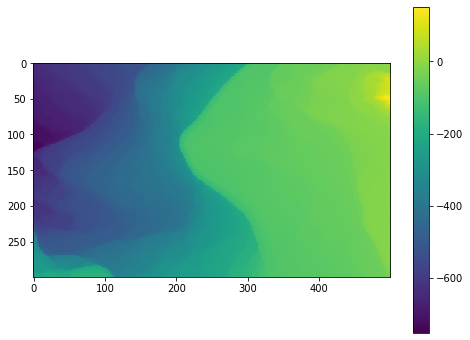

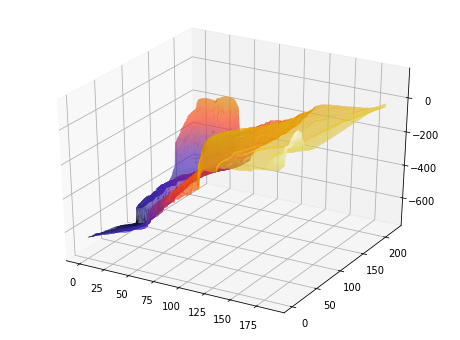

In [38]:
# Generating the surface
# x, y, z = get_test_data(delta=0.1)
# x += 30
# y += 30
# z = z_edit


# Scale the surface for this example
# z *= 0.05
# Remember that Gazebo uses ENU (east-north-up) convention, so underwater
# the Z coordinate will be negative
# z -= 3
# Note: Gazebo will import your mesh in meters. 

# Point clouds usually don't come in nice grids, so let's make it a (N, 3)
# matrix just to show how it can be done. If you have outliers or noise, you should
# treat those values now.
# xyz = np.zeros(shape=(x.size, 3))
xyz = np.zeros(shape=(z.shape[0], 3))
xyz[:, 0] = x.flatten()
xyz[:, 1] = y.flatten()
xyz[:, 2] = z.flatten()

# Generate a grid for the X and Y coordinates, change the number of points
# to your needs. Large grids can generate files that are too big for Gazebo, so
# be careful when choosing the resolution of your grid.
x_grid, y_grid = np.meshgrid(np.linspace(xyz[:, 0].min(), xyz[:, 0].max(), 500),
                             np.linspace(xyz[:, 1].min(), xyz[:, 1].max(), 300))

# Interpolate over the point cloud for our grid
z_grid = np.flipud(griddata(xyz[:, 0:2], xyz[:, 2], (x_grid, y_grid),
                  method='linear'))

# Option to treat noise
#z_grid = gaussian_filter(z_grid, sigma=1)

# Show the resulting heightmap as an image
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
im = plt.imshow(z_grid)
fig.colorbar(im)

# Flatten our interpolated data for triangulation
output = np.zeros(shape=(x_grid.size, 3))
output[:, 0] = x_grid.flatten()
output[:, 1] = y_grid.flatten()
output[:, 2] = z_grid.flatten()

# Triangulation of the interpolated data
tri = mtri.Triangulation(output[:, 0], output[:, 1])

# Show the resulting surface
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(tri, output[:, 2], cmap=plt.cm.CMRmap, shade=True, linewidth=0.1)
# ax.axis('equal')

# Create the mesh object
seabed_mesh = mesh.Mesh(np.zeros(tri.triangles.shape[0], dtype=mesh.Mesh.dtype))

# Set the vectors
for i, f in enumerate(tri.triangles):
    for j in range(3):
        seabed_mesh.vectors[i][j] = output[f[j]]

# Store the seabed as a STL file
seabed_mesh.save('lajolla.stl')

plt.show()